In [1]:
import pandas as pd
from sqlalchemy import text
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

In [2]:
sqlite_path = "../data_collection/reddit_ed_0.6.0.sqlite3"
engine = create_engine(
    f"sqlite:///{sqlite_path}",
    connect_args={"check_same_thread":False},
)

In [3]:
from sqlalchemy import inspect
inspector = inspect(engine)
schemas = inspector.get_schema_names()

for schema in schemas:
    print("schema: %s" % schema)
    for table_name in inspector.get_table_names(schema=schema):
        print("table: %s" % table_name)
        for column in inspector.get_columns(table_name, schema=schema):
            print("Column: %s" % column)

schema: main
table: filtered_200
Column: {'name': 'subreddit', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'selftext', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'author_fullname', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'title', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'score', 'type': INTEGER(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'link_flair_css_class', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'link_flair_text', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'author_flair_type', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'over_18', 'type': NUMERIC(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'author_flair_text', 'type': TEXT

In [4]:
query = f"select * from subreddit_submission_metadata"
df = pd.read_sql_query(text(query),con=engine.connect())
df.head()


,subreddit,selftext,author_fullname,title,score,link_flair_css_class,link_flair_text,author_flair_type,over_18,author_flair_text,subreddit_id,id,is_self,author,author_flair_css_class,permalink,url,created_utc
0,EatingDisorders,23 F. I just started treatment for an eating d...,None,I need moral support,1,,Seeking Support,None,None,None,t5_2qpcj,10poqxu,1,GullibleCup27,None,/r/EatingDisorders/comments/10poqxu/i_need_mor...,https://www.reddit.com/r/EatingDisorders/comme...,1675140001
1,EatingDisorders,I 26 f told the truth for the first time about...,None,Opening up about my ed,1,,Seeking Support,None,None,None,t5_2qpcj,10pnoxo,1,mistinthrowaway,None,/r/EatingDisorders/comments/10pnoxo/opening_up...,https://www.reddit.com/r/EatingDisorders/comme...,1675137504
2,EatingDisorders,[removed],None,My Long Battle With Binge Eating Coming To An End,1,one,Recovery Story,None,None,None,t5_2qpcj,10plv3v,1,LetMeTuckYouInHomie,None,/r/EatingDisorders/comments/10plv3v/my_long_ba...,https://www.reddit.com/r/EatingDisorders/comme...,1675132759
3,EatingDisorders,"Greetings,\n\nA research team from Carnegie Va...",None,[Mod Approved] Are you a man who has experienc...,1,None,None,None,None,None,t5_2qpcj,10pkd8e,1,Acceptable_Ad_3206,None,/r/EatingDisorders/comments/10pkd8e/mod_approv...,https://www.reddit.com/r/EatingDisorders/comme...,1675128549
4,EatingDisorders,Idk who to talk to about this so I resort to r...,None,Just ranting ig,1,None,None,None,None,None,t5_2qpcj,10pjinj,1,tomato_bean876,None,/r/EatingDisorders/comments/10pjinj/just_ranti...,https://www.reddit.com/r/EatingDisorders/comme...,1675126245


## Pre-processing

### Remove very short posts or posts are removed

<Axes: >

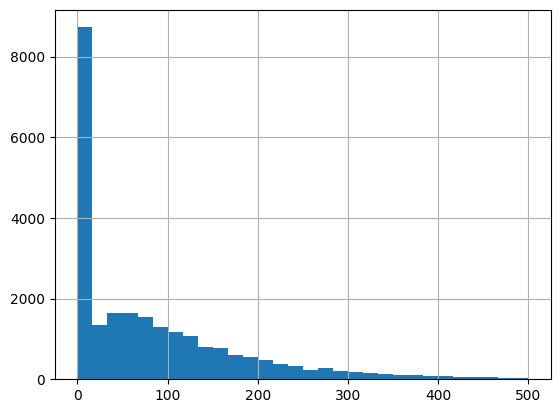

In [5]:
df["num_words"] = df["selftext"].apply(lambda x: len(x.split()))
df["num_words"].hist(bins=30, range=[0,500])

In [6]:
word_length_cutoff = 100 # set a very low threshold
print(f"Number of short posts: {len(df[df['num_words'] < word_length_cutoff])}")
filtered_df = df[df["num_words"] >= word_length_cutoff]
print(f"Number of filtered posts (by word length): {len(filtered_df)}")

Number of short posts: 16244
Number of filtered posts (by word length): 8402


### Preprocess flair falgs

In [7]:
filtered_df["link_flair_text"] = filtered_df["link_flair_text"].apply(lambda x: x.lower().strip() if x is not None else "")

/var/folders/fj/7t9sn4pn7t993nnng_9lyxtr0000gn/T/ipykernel_88681/1831028574.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["link_flair_text"] = filtered_df["link_flair_text"].apply(lambda x: x.lower().strip() if x is not None else "")


In [8]:
filtered_df["link_flair_text"].unique()

array(['seeking support', '', 'question', 'recovery story', 'information',
       'trigger warning', 'tw: numbers', 'family problems', 'be/d',
       'tw: photos', 'rant / rave', 'tw', 'discussion', 'story time',
       'recovery wins!', 'oh no', 'fatphobia', 'tw venting abt food',
       'shitpost', 'food', 'harm reduction', 'educational',
       'recovery support', 'trans/nb', 'family vent', 'substance abuse',
       'tw : some numbers', 'lgbtq+', 'tw vent', 'tw: sa, csa mention',
       'tw: appetite suppression', 'triggering phrase',
       'tw sexual harassment', 'tw: numbers, references to self harm',
       'tw: fatphobia', 'meta', 'tw (ed + fatphobia)',
       'tw: numbers, mentioned throwing up, choking, rapid weight loss',
       'tw: just generally gross', 'tw ed started young, bmi, hw, uw,',
       'tw: food', 'harm reduction, tw: numbers',
       'tw - scared into recovery', 'tw substance abuse (some #’s)',
       'tw: help me', 'tw //  vent/rant + mention of relapse',
   

## Narrative Detection

In [9]:
positive_flags = ["story", "progress", "recovery", "support", "rant", "vent", "success"]
negative_flags = ["announcement", "educational", "research request", "resources", "advertise", "link", "information", "discussion"]
uncertain_flags = ["question", "advice", "tw"]

In [10]:
import re
positive_flag_regex = ".*(" + ")|(".join(positive_flags) + ").*"
negative_flag_regex = ".*(" + ")|(".join(negative_flags) + ").*"
uncertain_flag_regex = ".*(" + ")|(".join(uncertain_flags) + ").*"

In [11]:
filtered_df["narrative_positive"] = filtered_df["link_flair_text"].apply(lambda x: 1 if re.match(positive_flag_regex, x) else 0)
filtered_df["narrative_negative"] = filtered_df["link_flair_text"].apply(lambda x: 1 if re.match(negative_flag_regex, x) else 0)
filtered_df["narrative_uncertain"] = filtered_df["link_flair_text"].apply(lambda x: 1 if re.match(uncertain_flag_regex, x) else 0)

/var/folders/fj/7t9sn4pn7t993nnng_9lyxtr0000gn/T/ipykernel_88681/1589716092.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["narrative_positive"] = filtered_df["link_flair_text"].apply(lambda x: 1 if re.match(positive_flag_regex, x) else 0)
/var/folders/fj/7t9sn4pn7t993nnng_9lyxtr0000gn/T/ipykernel_88681/1589716092.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["narrative_negative"] = filtered_df["link_flair_text"].apply(lambda x: 1 if re.match(negative_flag_regex, x) else 0

In [12]:
pd.set_option('display.max_colwidth', None)

In [44]:
def get_analysis_info(data: pd.DataFrame, type: str):
    column_name = f"narrative_{type}"
    print(f"Number of {type}: {sum(data[column_name])} / {len(data)}")
    print(f"Values of flair flags: {data[data[column_name] == 1]['link_flair_text'].unique()}")
    return data[data[column_name] == 1][["title","link_flair_text", "selftext", "num_words", "author", "subreddit_id", "id", "created_utc"]]

#### Narrative Positive

In [45]:
narrative_positive_df = get_analysis_info(filtered_df, "positive")
narrative_positive_df.sort_values("num_words", ascending=False)

Number of positive: 1388 / 8402
Values of flair flags: ['recovery story' 'rant / rave' 'story time' 'recovery wins!'
 'recovery support' 'recovery related' 'vent' 'vent- trigger warning'
 'support needed' 'recovery win' ':karma:personal story:karma:' 'success'
 'my story' 'ranty-rant-rant' 'progress']


title  \
8890                                                                                                          Need advice, don’t know where else to go.   
9808   (huge TW) the whole world is so shallow. because of the way i was treated when i was unattractive, i am the most hateful, cynical person i know.   
20101                                          I Lived, Bitch (Minor trigger warning. Skip to the recovery tips if you aren't down for the boring shit)   
8342                                                                                                                          I don’t know what I want.   
7637            had a binge/extreme hunger episode yesterday but...i don't feel upset? very confused (spoilered numbers so shouldn't be too triggering)   
...                                                                                                                                                 ...   
9758                                                                                                   “by the time you leave, you’ll be your SW again”   
9835                                                                                                                                not this shit again   
23982                                                                                                                                Back in the binge…   
21459                                                                                                                                           Relapse   
8709                                                                                                                                Big wide rib cage!!   

        link_flair_text  \
8890   recovery support   
9808        rant / rave   
20101    recovery story   
8342   recovery support   
7637         story time   
...                 ...   
9758        rant / rave   
9835        rant / rave   
23982    support needed   
21459              vent   
8709        rant / rave   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

<Axes: >

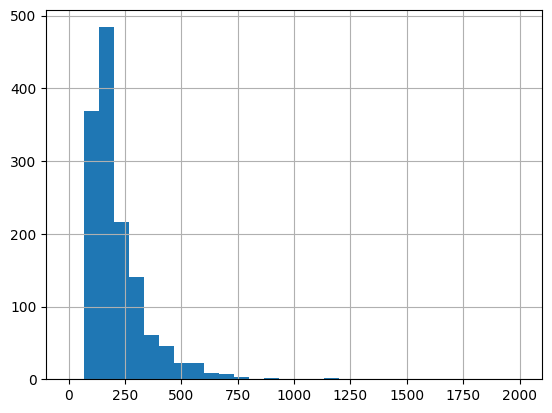

In [15]:
narrative_positive_df["num_words"].hist(bins=30, range=[0,2000])

In [46]:
narrative_positive_df.to_csv("narrative_posts_by_flair.csv", index=False)

#### Narrative Negative

In [16]:
narrative_negative_df = get_analysis_info(filtered_df, "negative")
narrative_negative_df.sort_values("num_words", ascending=False)

Number of negative: 312 / 8402
Values of flair flags: ['information' 'discussion' 'educational' 'link' 'announcement'
 'resources' 'research request - ca, usa' 'research request'
 'research request (mod approved)']


,title,link_flair_text,selftext,num_words
8046,Is it possible to develop ARFID after a more weight based ed?,discussion,"So I was looking into ARFID + apparently the border between ARFID + eds like anorexia is a concern w weight + stuff like that, but I know it's very possible to have both, normally though people had ARFID first + often since early childhood.\n\nShould probably put here I'm not asking for you to tell me if I have ARFID or not, I'll leave that to a professional when I can see one\n\nI don't know if I have ARFID, but I was wondering if it's even worth bringing up as a possibility when I finally get a new team. My current diagnosis is bulimia, although my behaviours most resemble anorexia atm but eh let's just leave it as ""og ed"" for now as the behaviours were in place before this new food struggle + I don't wanna claim which one I have fs as idk atm\n\nI've always had lots of difficulties w food due to my autism, often texture smell + colour (I can eat foods that taste bad, I just prefer not to ofc) leading to occasional nutritional difficulties (iron + vitamin D) + once when I was placed in inpatient + they chose not to accommodate my autism food needs (they could have as they did for another patient) I lost a significant amount of weight as I chose to not eat anything instead of eating the bad foods.\n\nHowever recently my swallowing got to the point where many foods keep getting stuck in my throat + as a result I've significantly cut down the amount of foods I feel I can eat + I'm normally having to have 2 protein shakes a day (1 w added vitamins + minerals) + a gummy vitamin to keep a diet that mostly meets my nutritional needs (not fully bc I'm still restricting, but before then I'd have more normal foods like meat + fruits I now can't eat). I won't count my weightloss towards it as that is intentional + don't have my next full blood count until the end of the year so won't know if I'm deficient in anything until then but doubt I am\n\nI feel like before I would have had it easily explained by my autism diagnosis as I was still eating a pretty large variety of food + other than the occasional deficiency I didn't have any issues as I could eat a large variety of foods, just there were still a fair few I wouldn't eat but now it's definitely so much worse + is really impacting my social life as I'm scared to go out for a meal or stay at my mum's as I know it'll be hard to find food I can eat. I ordered protein shakes to my mum's house as I'm getting the train down soon + I want smth I know I can eat. I do however have a great desire to lose weight stemming from the og ed which apparently can mean you don't qualify as having ARFID? But honestly these restrictions have nothing to do w my weight + body - lots of them are low calorie nutritionally desne foods I've eaten v happily when restricting like chicken breasts + peaches or foods I've still loved throughout my ed + still counted as safe foods as the texture was fine, I'd just limit the portions like onion rings + chicken nuggets\n\nI think I would like to change it. I miss foods like chicken breasts + wings + stuff, I'm just really worried about it getting stuck as many foods were getting stuck + once I ||was retching + coughing + drooling so hard from having smth stuck. Water didn't work, fizzy drink didn't work, more food didn't work I just had to wait|| it was honestly rly awful + likely what caused me to refuse to eat so many foods that haven't got stuck before. Idk, I think it is a very valid fear but also I think I've taken it to an extreme length as a fair amount of these foods haven't got stuck just I'm too scared to try them incase they do + honestly I'm an adult, I can eat what I want, I don't see why I should have to. But then I really want to eat them. Idk ig I'm conflicted?\n\nSorry this is a massive text wall I ramble a lot. Tldr; can ARFID develop after an eating disorder like anorexia/bulimia is already developed? Is it worth bringing up th

#### Narrative Uncertain

In [17]:
get_analysis_info(filtered_df, "uncertain")

Number of uncertain: 918 / 8402
Values of flair flags: ['question' 'tw: numbers' 'tw: photos' 'tw' 'tw venting abt food'
 'tw : some numbers' 'tw vent' 'tw: sa, csa mention'
 'tw: appetite suppression' 'tw sexual harassment'
 'tw: numbers, references to self harm' 'tw: fatphobia'
 'tw (ed + fatphobia)'
 'tw: numbers, mentioned throwing up, choking, rapid weight loss'
 'tw: just generally gross' 'tw ed started young, bmi, hw, uw,' 'tw: food'
 'tw - scared into recovery' 'tw substance abuse (some #’s)' 'tw: help me'
 'tw //  vent/rant + mention of relapse' 'tw: bulimia, binge eating'
 'tw negitive self talk' 'tw: relaps' 'tw- numbers'
 'tw: binging, laxative abuse, relapse' 'tw weight gain'
 'tw potential description of restrictive behaviours' 'tw: rant'
 'tw sexual abuse' 'tw calories and numbers' 'tw: edtwt'
 ':snoo_thoughtful: i have a question. . .' 'advice' 'advice needed']


,title,link_flair_text,selftext,num_words
21,Helping out my girlfriend!!,question,"alright, so, well i dont know how to phrase this well, but my girlfriend has been going through a tough time recently with a vv big relapse on her ED recovery journey, and its quite apparent that she finds it hard to recover again. she seems quite drained and tired from all of that, and she does not want to talk to a counsellor about it as she is afraid her parents would be informed. ive been trying my best to emotionally support her, just watch out for her and stuff like that! i encourage her to eat, but i dont force! same for recovery and all that... its quite emotionally draining for me too, but i can cope with that alright! so that is alright on my end... i just would like to know from all of you here, what motivated you to recover? how can a loved one best support someone suffering from an ED? what is something you wish someone would say or do when you are in recovery?",172
23,Friend with ED won’t let people call her baby chubby,question,"I have a girlfriend who’s recovering. She had a baby last year and per her mom, it really bothers her if people call her baby chunky or chubby or comment on baby’s fat leg rolls. Also she took like one photo of herself while pregnant. \nNow I’m not in the ED community or anything similar so I DO NOT want to upset or offend anyone but I just think this is ludicrous. I personally loved seeing pix of my mother glowing and pregnant with me. And babies ARE beautifully wonderfully perfectly chubby! \nI just don’t understand at all but I’m not gonna say this to her. Just wondering if this is typical?\nAgain I’m sorry if my thoughts on this upset you - that’s not my intention.",127
39,How do I become comfortable with socially eating?,question,"I’m recovering from BED and haven’t binged in probably six months. I’m proud of the progress I have made, but I’m still going through some mental anguish. This is mainly in regards to socially eating. So I have a group of friends that are foodies and basically want to go out to eat a lot. I love hanging out with them, but every time I hang out with them, the event revolves around food or going to a restaurant. Every time I go and eat with them, I feel immense guilt and self-hatred afterwards. Even if the food is super good, I still hate myself afterwards. My closest friend in that group has reassured me that it will be okay if I have a day where I eat good food. She has even said that life is too short for bad food. I want to feel empowered by that, but I just can’t. When I eat food at a restaurant, I can’t shake the feeling that I’m wrong and disgusting. I feel like I’m going to go back to my old ways and I’m just super negative in my head after I go out to eat with them. Also I feel like if I go and say no to food, people are going to ask me why and I just don’t feel like telling them a whole story. I love hanging out with them, but I don’t know what to do to resolve my bad emotions.",246
44,does anyone have tips on trying to get out of a relapse?,question,"I was diagnosed w OSFED (atypical anorexia) in 2021, and started treatment at the emily program, which i stopped at the end of last year (combo of no time or energy for therapy, cost, and i wasn’t the biggest fan of my therapist). while my eating habits have gotten very consistent and i am fine with most types of food, i do tend to binge occasionally (esp on super sugary foods) and am started to get somewhat fixated on what i’m eating like i used to. \n\ni’ve been trying to not get as caught up in it, and also just feed myself and buy snacks that are enjoyable but still healthy for me. but i’m wondering if people have tips on establishing regular eating patterns and also just not relapsing.\n\ni’m terrified of weight gain and though i haven’t decreased my food intake yet (i’ve started training for a half marathon so i’ve been eating well), i’m scared i will eventually get to that point.\n\nthank you so much!",169
72,Adv

In [18]:
filtered_df.to_csv("filtered_posts_without_classification.csv", index=False)

### Training a Classifier for Narrative Detection

#### Data Preparation

In [19]:
labeled_data = filtered_df
print(labeled_data.columns)
labeled_data["narrative_label"] = labeled_data.apply(lambda x: 1 if x["narrative_positive"] == 1 else (0 if x["narrative_negative"] else -1), axis=1)
labeled_data = labeled_data[labeled_data["narrative_label"] != -1]
print(f"Number of rows: {len(labeled_data)}")
labeled_data["narrative_label"].value_counts()
                                                     

Index(['subreddit', 'selftext', 'author_fullname', 'title', 'score',
       'link_flair_css_class', 'link_flair_text', 'author_flair_type',
       'over_18', 'author_flair_text', 'subreddit_id', 'id', 'is_self',
       'author', 'author_flair_css_class', 'permalink', 'url', 'created_utc',
       'num_words', 'narrative_positive', 'narrative_negative',
       'narrative_uncertain'],
      dtype='object')
Number of rows: 1700


/var/folders/fj/7t9sn4pn7t993nnng_9lyxtr0000gn/T/ipykernel_88681/3499755252.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_data["narrative_label"] = labeled_data.apply(lambda x: 1 if x["narrative_positive"] == 1 else (0 if x["narrative_negative"] else -1), axis=1)


1    1388
0     312
Name: narrative_label, dtype: int64

In [20]:
from torch.utils.data import Dataset, DataLoader
import torch

class RedditPostDataset(Dataset):
    def __init__(self, posts, labels, tokenizer, max_len):
        self.posts = posts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.posts)
  
    def __getitem__(self, item):
        post = str(self.posts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
          post,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )
        return {
            
          'post_text': post,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
        }

In [21]:
from sklearn.model_selection import train_test_split
RANDOM_SEED = 12

df_train, df_test = train_test_split(
  labeled_data,
  test_size=0.4,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [22]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


train_dataset = RedditPostDataset(
    df_train["selftext"].values,
    df_train["narrative_label"].values,
    tokenizer = tokenizer,
    max_len = 500
)
print(f"Train size: {len(train_dataset)}")
print(df_train["narrative_label"].value_counts())

train_data_loader = DataLoader(train_dataset, batch_size = 16)


val_dataset = RedditPostDataset(
    df_val["selftext"].values,
    df_val["narrative_label"].values,
    tokenizer = tokenizer,
    max_len = 500
)
print(f"Validation size: {len(val_dataset)}")
print(df_val["narrative_label"].value_counts())
val_data_loader = DataLoader(val_dataset, batch_size = 16)


test_dataset = RedditPostDataset(
    df_test["selftext"].values,
    df_test["narrative_label"].values,
    tokenizer = tokenizer,
    max_len = 500
)
print(f"Test size: {len(test_dataset)}")
print(df_test["narrative_label"].value_counts())

test_data_loader = DataLoader(test_dataset, batch_size = 16)
    




/Users/trangnguyen/miniforge3/envs/cs685-narrative-analysis/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train size: 1020
1    832
0    188
Name: narrative_label, dtype: int64
Validation size: 340
1    281
0     59
Name: narrative_label, dtype: int64
Test size: 340
1    275
0     65
Name: narrative_label, dtype: int64


#### Training

In [23]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

narrative_detection_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [24]:
import numpy as np
# function to get validation accuracy
def get_validation_performance(model, val_set, device = torch.device("cpu")):
    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0

    total_correct = 0

    wrong_indexes = []

    for i, batch in enumerate(val_set):

        input_id_tensors = batch["input_ids"]
        input_mask_tensors = batch["attention_mask"]
        label_tensors = batch["label"]
      
        # Move tensors to the GPU
        batch_size = input_id_tensors.shape[0]
        b_input_ids = input_id_tensors.to(device)
        b_input_mask = input_mask_tensors.to(device)
        b_labels = label_tensors.to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
          # Forward pass, calculate logit predictions.
            outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits

            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the number of correctly labeled examples in batch
            pred_flat = np.argmax(logits, axis=1).flatten()
            labels_flat = label_ids.flatten()
            num_correct = np.sum(pred_flat == labels_flat)
            total_correct += num_correct

            # Return wrong IDs
            wrong_indexes.extend([i*batch_size + index for index in range(len(pred_flat)) if pred_flat[index] != labels_flat[index]])
        
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_correct / len(val_set.dataset)
    return avg_val_accuracy, wrong_indexes

In [25]:
def finetune_model(model, epochs, optimizer, train_dataloader, val_dataloader, device = torch.device("cpu")):
    # training loop
    model.to(device)
    model.train()
    best_accuracy = 0
    # For each epoch...
    for epoch_i in range(0, epochs):
        # Perform one full pass over the training set.
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Reset the total loss for this epoch.
        total_train_loss = 0

        # Put the model into training mode.
        model.train()
        
        


        for i, batch in enumerate(train_dataloader):
            print(f"Batch {i}")
            input_id_tensors = batch["input_ids"]
            input_mask_tensors = batch["attention_mask"]
            label_tensors = batch["label"]

            # Move tensors to the GPU
            b_input_ids = input_id_tensors.to(device)
            b_input_mask = input_mask_tensors.to(device)
            b_labels = label_tensors.to(device)

            # Clear the previously calculated gradient
            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch).
            outputs = model(b_input_ids, 
                                  token_type_ids=None, 
                                  attention_mask=b_input_mask, 
                                  labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits

            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Update parameters and take a step using the computed gradient.
            optimizer.step()

      # ========================================
      #               Validation
      # ========================================
      # After the completion of each training epoch, measure our performance on
      # our validation set. Implement this function in the cell above.
        print(f"Total loss: {total_train_loss}")
        val_acc, _ = get_validation_performance(model, val_dataloader, device=device)
        print(f"Validation accuracy: {val_acc}")
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            torch.save(model.state_dict(), "narrative_detection_model_state_dict.pt")
      
    print("")
    print("Training complete!")
    return model, val_acc


In [26]:
finetuned_model, validation_accuracy = finetune_model(narrative_detection_model, epochs = 2, 
                                                      optimizer = AdamW(narrative_detection_model.parameters(), lr=5e-5, eps = 1e-8),
                                                     train_dataloader = train_data_loader,
                                                     val_dataloader = val_data_loader,
                                                     device = torch.device("mps"))

/Users/trangnguyen/miniforge3/envs/cs685-narrative-analysis/lib/python3.8/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/trangnguyen/miniforge3/envs/cs685-narrative-analysis/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='l


======== Epoch 1 / 2 ========
Training...
Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60
Batch 61
Batch 62
Batch 63
Total loss: 28.485356748104095
Validation accuracy: 0.8382352941176471

======== Epoch 2 / 2 ========
Training...
Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31

In [27]:
# Load best model
best_narrative_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
best_narrative_model.load_state_dict(torch.load("narrative_detection_model_state_dict.pt"))
best_narrative_model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [28]:
get_validation_performance(best_narrative_model, test_data_loader)

(0.8588235294117647,
 [0,
  6,
  17,
  24,
  35,
  37,
  43,
  47,
  57,
  61,
  64,
  84,
  92,
  114,
  120,
  125,
  135,
  136,
  138,
  149,
  161,
  166,
  173,
  175,
  189,
  191,
  194,
  195,
  196,
  197,
  200,
  202,
  205,
  206,
  222,
  236,
  238,
  257,
  263,
  272,
  280,
  281,
  292,
  304,
  306,
  318,
  323,
  324])

In [49]:
import torch.nn as nn

def classify_narrative(post: str, narrative_model: nn.Module, device = torch.device("cpu")):
    # Run Prediction
    encoding = tokenizer.encode_plus(
          post,
          add_special_tokens=True,
          max_length=500,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )
    input_ids = encoding["input_ids"].flatten()
    attention_masks = encoding["attention_mask"].flatten()
    input_ids = input_ids.to(device)
    attention_masks = attention_masks.to(device)
    outputs = narrative_model(input_ids.unsqueeze(dim=0), 
                    token_type_ids=None, 
                    attention_mask=attention_masks.unsqueeze(dim=0),
    )
                    #labels=b_labels)
    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    pred_flat = np.argmax(logits, axis=1).flatten()
    return pred_flat[0]

In [50]:
filtered_df["predicted_narrative_label"] = filtered_df["selftext"].apply(lambda x: classify_narrative(x, 
                                                                                                      best_narrative_model,
                                                                                                     torch.device("cpu")))

/var/folders/fj/7t9sn4pn7t993nnng_9lyxtr0000gn/T/ipykernel_88681/2960291488.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["predicted_narrative_label"] = filtered_df["selftext"].apply(lambda x: classify_narrative(x,


In [51]:
filtered_df.to_csv("filtered_posters_with_classification.csv", index=False)

In [58]:
len(filtered_df.loc[(filtered_df["predicted_narrative_label"] == 0) & (filtered_df["narrative_label"] == 1)])

15

In [59]:
filtered_df.loc[(filtered_df["predicted_narrative_label"] == 1)].to_csv("narrative_posts_by_trained_classification.csv")

In [ ]:
len(filtered_df.loc[(filtered_df["predicted_narrative_label"] == 1)]